# Analiza opinii z Twittera

Wykorzystano hashtag **#premierleague** do badania opinii z Twittera na temat angielskiej ligi Premier League. Baza obejmuje 10000 tweetów powiązanych z tym tematem. Użyto narzędzia **snscrape** do pobierania tweetów.

In [1]:
import snscrape.modules.twitter as sntwitter

def get_tweets(hashtag, num):
    tweets = []

    query = f'#{hashtag}'
    for tweet in sntwitter.TwitterHashtagScraper(query).get_items():

        tweets.append({
            'rawContent': str(tweet.rawContent).replace('\n', ''),
            'date': tweet.date,
            'lang': tweet.lang
        })

        if len(tweets) >= num:
            break

    with open('tweets.csv', 'w', encoding='utf-8', newline='') as file:
        fieldnames = ['rawContent', 'date', 'lang']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for tweet in tweets:
            writer.writerow(tweet)

    print("Pomyślnie zapisano do pliku tweets.csv")

hashtag = 'premierleague'
num_tweets = 10000

get_tweets(hashtag, num_tweets)


Unavailable user in card on tweet 1663581686465003520
Unavailable user in card on tweet 1663581686465003520
User 819188347314851843 not found in user refs in card on tweet 1663581686465003520
User 819188347314851843 not found in user refs in card on tweet 1663581686465003520
Unavailable user in card on tweet 1663580940675710978
Unavailable user in card on tweet 1663580940675710978
User 819188347314851843 not found in user refs in card on tweet 1663580940675710978
User 819188347314851843 not found in user refs in card on tweet 1663580940675710978
Unavailable user in card on tweet 1663579740135882755
Unavailable user in card on tweet 1663579740135882755
User 819188347314851843 not found in user refs in card on tweet 1663579740135882755
User 819188347314851843 not found in user refs in card on tweet 1663579740135882755
Could not translate t.co card URL on tweet 1663561565055102977
Unavailable user in card on tweet 1663560461101719555
Unavailable user in card on tweet 1663560461101719555
U

Pomyślnie zapisano do pliku tweets.csv


# Preprocessing bazy danych

Przed przeprowadzeniem analizy opinii, konieczna jest obróbka pobranych tweetów. Tweety zostały przetłumaczone na angielski z użyciem googletrans. Zostały również dodane wyjątki w przypadku niektórych skrajnych i niespotykanych języków.

In [59]:
from googletrans import Translator

def translate_tweets():
    translated_tweets = []

    with open('tweets.csv', 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        translated_tweet = ''
        for row in reader:
            translator = Translator(service_urls=['translate.googleapis.com'])
            tweet_content = row['rawContent']
            lang = row['lang']

            if lang != 'en':
                if lang == 'in':
                    translated_tweet = translator.translate(tweet_content, dest='en', src='es').text
                elif lang == 'zh':
                    translated_tweet = translator.translate(tweet_content, dest='en', src='zh-cn').text
                elif lang not in ['zxx', 'und', 'qme', 'qht', 'qst', 'qam']:
                    translated_tweet = translator.translate(tweet_content, dest='en', src=lang).text
            else:
                translated_tweet = tweet_content

            translated_tweets.append({'translatedContent': translated_tweet, 'date': row['date']})

    print('Pomyślnie przetłumaczono tweety!')

    with open('translated_tweets.csv', 'w', encoding='utf-8', newline='') as file:
        fieldnames = ['translatedContent', 'date']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for tweet in translated_tweets:
            writer.writerow(tweet)

    print('Przetłumaczone tweety zostały zapisane do pliku translated_tweets.csv')

translate_tweets()


Pomyślnie przetłumaczono tweety!
Przetłumaczone tweety zostały zapisane do pliku translated_tweets.csv


Następnie wykonano kroki dla Bag of Words czyli tokenizację, stopwords i lematyzację. Dodatkowo usunięto zbędne znaki interpunkcję oraz użytkowników na podstawie znaku `@` przed ich nazwami, a do stopwords dodano napisy z premier league. Ujednolicono również daty:

In [60]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

def preprocess_tweet(tweet):
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)

    tokens = nltk.word_tokenize(tweet)
    tokens = [token for token in tokens if token.isalpha()]

    stop_words = set(stopwords.words('english'))
    stop_words.add('premier')
    stop_words.add('Premier')
    stop_words.add('league')
    stop_words.add('League')
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    preprocessed_tweet = ' '.join(tokens)
    return preprocessed_tweet

def preprocess_tweets():
    preprocessed_tweets = []

    with open('translated_tweets.csv', 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            translated_tweet = row['translatedContent']
            preprocessed_tweet = preprocess_tweet(translated_tweet)
            date_str = row['date']
            date_parts = date_str.split()
            date = date_parts[0]
            preprocessed_tweets.append({'preprocessedContent': preprocessed_tweet, 'date': date})

    with open('preprocessed_tweets.csv', 'w', encoding='utf-8', newline='') as file:
        fieldnames = ['preprocessedContent', 'date']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for tweet in preprocessed_tweets:
            writer.writerow(tweet)

    print('Przetworzone tweety zostały zapisane do pliku preprocessed_tweets.csv!')

preprocess_tweets()


Przetworzone tweety zostały zapisane do pliku preprocessed_tweets.csv!


# Analiza opinii

Pierwszym krokiem jest wykonanie **analizy całościowej** i narysowanie chmurek. Tweet z neutralnością powyżej 0.5 nie jest brany pod uwagę, tak samo jak opinia której wartość pozytywna/negatywna nie przekroczy 0.5.


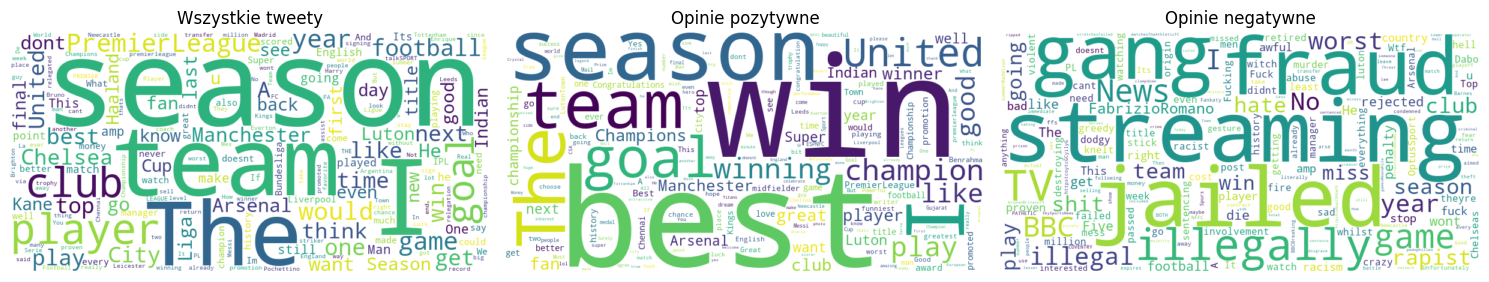

In [61]:
import csv
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

tweets = []

with open('preprocessed_tweets.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        words = row['preprocessedContent'].split()
        tweets.append(words)

analyzer = SentimentIntensityAnalyzer()
sentiments = [analyzer.polarity_scores(' '.join(tweet)) for tweet in tweets]

positive_tweets = [tweet for tweet, sentiment in zip(tweets, sentiments) if sentiment['pos'] > 0.5 > sentiment['neu'] and sentiment['pos'] > sentiment['neg']]
negative_tweets = [tweet for tweet, sentiment in zip(tweets, sentiments) if sentiment['neg'] > 0.5 > sentiment['neu'] and sentiment['neg'] > sentiment['pos']]

all_words = [word for tweet in tweets for word in tweet]
all_words_freq = FreqDist(all_words)
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_words_freq)

positive_words = [word for tweet in positive_tweets for word in tweet]
positive_words_freq = FreqDist(positive_words)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_words_freq)

negative_words = [word for tweet in negative_tweets for word in tweet]
negative_words_freq = FreqDist(negative_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_words_freq)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Wszystkie tweety')

plt.subplot(132)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Opinie pozytywne')

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Opinie negatywne')

plt.tight_layout()
plt.show()


Następnie dokonano analizę czasową.

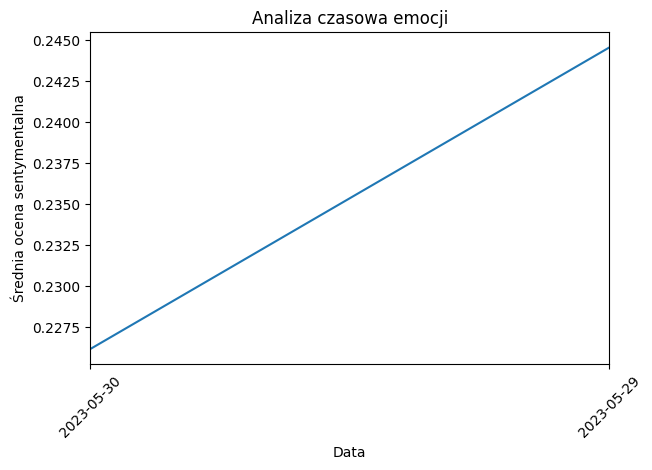

In [65]:
import csv
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict

dates_sentiments = defaultdict(list)

with open('preprocessed_tweets.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        date = row['date']

        tweet = row['preprocessedContent']
        analyzer = SentimentIntensityAnalyzer()
        sentiment = analyzer.polarity_scores(tweet)
        compound_sentiment = sentiment['compound']

        dates_sentiments[date].append(compound_sentiment)

dates = list(dates_sentiments.keys())
averaged_emotions = [sum(sentiments) / len(sentiments) for sentiments in dates_sentiments.values()]

# Tworzenie wykresu liniowego
plt.plot(dates, averaged_emotions)

plt.xlabel('Data')
plt.ylabel('Średnia ocena sentymentalna')
plt.title('Analiza czasowa emocji')

plt.xticks(rotation=45)
plt.tight_layout()

# Ustawienie zakresu osi x na większy okres
plt.xlim(dates[0], dates[-1])

plt.show()

### Data dzisiejsza i wczorajsza
